# DTU - Uncertainity Quantification Assessment

#### 0.1 - Set Up

In [2]:
# Library Imports
import copy
import math
from math import log, sqrt
from matplotlib import pylab as plt
import openturns as ot
import openturns.viewer as viewer
import pandas as pd
from scipy.optimize import minimize
from pathlib import Path

In [27]:
# Importing the data

# Set Up Path
import pathlib
path = pathlib.Path().resolve()
input_path_site = path / 'inputs/SB/SB_data_1_month_of_10_minute_observations.csv'
input_path_reliability = path / 'inputs/Reliability/phd_school_input_output_data_clean.csv'
output_path = path / 'outputs'

# Data Import
site_data_sb_10_min = ot.Sample.ImportFromCSVFile(str(input_path_site),";")
reliability_data = ot.Sample.ImportFromCSVFile(str(input_path_reliability),";")

# Seperating Columns for Inspection
wind_direction_sb_10_min = site_data_sb_10_min[:,0]
wind_direction_relative_sb_10_min = site_data_sb_10_min[:,1]
wave_period_sb_10_min = site_data_sb_10_min[:,2]
sig_wave_height_sb_10_min = site_data_sb_10_min[:,3]
std_dev_streamwise_wind_sb_10_min = site_data_sb_10_min[:,4]
wind_speed_sb_10_min = site_data_sb_10_min[:,5]

In [4]:
# Importing the Hiperwind Functions

def getBasicStatistics(sample):
    min_val = sample.getMin()[0]
    quartile_1 = sample.computeQuantile(0.25)[0]
    median_val = sample.computeMedian()[0]
    mean_val = sample.computeMean()[0]
    quartile_3 = sample.computeQuantile(0.75)[0]
    max_val = sample.getMax()[0]
    std_dev = sample.computeStandardDeviation()[0]

    statistics_df = pd.DataFrame({
        "Parameter": ["Min", "1st Quartile", "Median", "Mean", "3rd Quartile", "Max", "Std. Deviation"],
        "Value": [min_val, quartile_1, median_val, mean_val, quartile_3, max_val, std_dev]
    })

    return statistics_df

# Bivariate statistics Function - From Git
def getBivariateStatistics(sample):
    # Linear Correlation
    lc=sample.computeLinearCorrelation()[0,1]
    # Kendall's Tau
    kt=sample.computeKendallTau()[0,1]
    # Spearman's Rho
    sr=sample.computePearsonCorrelation()[0,1]
    # return
    return (lc,kt,sr)

#### 1.0 - Turbulence

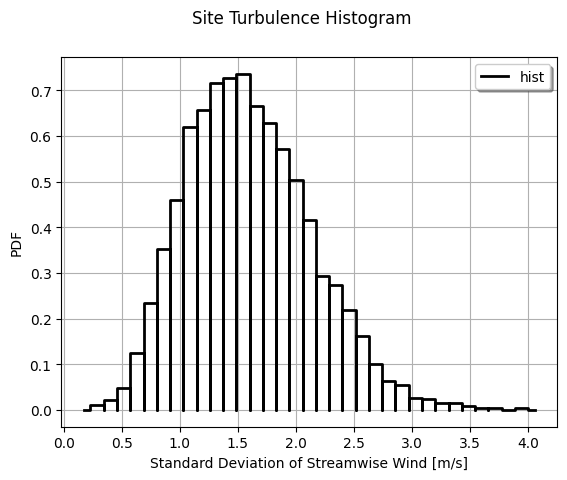

        Parameter     Value
0             Min  0.231282
1    1st Quartile  1.198872
2          Median  1.551559
3            Mean  1.598334
4    3rd Quartile  1.943875
5             Max  4.000615
6  Std. Deviation  0.538111


First Moment - Mean: 1.5983339258400335
Second Moment - Variance: 2.8441689038964544
Mean of Lognormal Distribution: 0.415288130873509
Standard Deviation of Lognormal Distribution: 0.3276390071299521
Lognormal Distribution: LogNormal(muLog = 0.415288, sigmaLog = 0.327639, gamma = 0)


In [5]:
# Establish Turbulence Statistics

# Plot Turbulence Histogram
site_turbulance_data = std_dev_streamwise_wind_sb_10_min
graph_site_turbulence = ot.HistogramFactory().build(site_turbulance_data).drawPDF()
graph_site_turbulence.setColors(["black"])
graph_site_turbulence.setLegends(["hist"])
graph_site_turbulence.setTitle("Site Turbulence Histogram")
view = viewer.View(graph_site_turbulence)
plt.show()

# Get Turbulence Statistics
turbulance_statistics = getBasicStatistics(site_turbulance_data)
print(turbulance_statistics)
print('\n')

# Method of Moments Characterisation
first_moment = site_turbulance_data.computeRawMoment(1)[0] # Mean
second_moment = site_turbulance_data.computeRawMoment(2)[0] # Variance
mu = log(first_moment*first_moment/sqrt(second_moment)) # Mean of Lognormal
sigma = sqrt(log(second_moment/(first_moment*first_moment))) # Standard Deviation of Lognormal
dist_mom = ot.LogNormal(mu,sigma,0.0) # Lognormal Distribution
print('First Moment - Mean:', first_moment)
print('Second Moment - Variance:', second_moment)
print('Mean of Lognormal Distribution:', mu)
print('Standard Deviation of Lognormal Distribution:', sigma)

print('Lognormal Distribution:', dist_mom)

#### 1.1 - Turbulence Fitting

##### 1.1.1 Best Fit So Far

In [6]:
# # Establish Liklihood Maximumization
# factory_mle_3f_weibull = ot.MaximumLikelihoodFactory(ot.WeibullMin())
# lowerBound=[1.5, 2.5, 0.0]
# upperBound=[2.0, 3.5, 1.0]
# bounds = ot.Interval(lowerBound, upperBound, [True,True,True], [True,True,True])
# factory_mle_3f_weibull.setOptimizationBounds(bounds)
# solver = factory_mle_3f_weibull.getOptimizationAlgorithm()
# solver.setStartingPoint([1.8,3.0,0.0])
# dist_mle_3 = factory_mle_3f_weibull.build(std_dev_streamwise_wind_sb_10_min)
# print(dist_mle_3)

# # Plotting Fitted Distribution over Histogram
# plt.rcParams['figure.figsize'] = [10, 5]
# graph_mle_3 = dist_mle_3.drawPDF()
# #graph_site_turbulence.add(graph_mle_3)
# test = ot.Graph()
# test.add(graph_mle_3)
# test.add(graph_site_turbulence)
# view = viewer.View(graph_site_turbulence)
# plt.show()

# # Plotting Q-Q Plot
# graph = ot.VisualTest.DrawQQplot(site_turbulance_data, dist_mle_3)
# view = viewer.View(graph)
# plt.show()



##### 1.1.2 Testing Different Fitting Methods

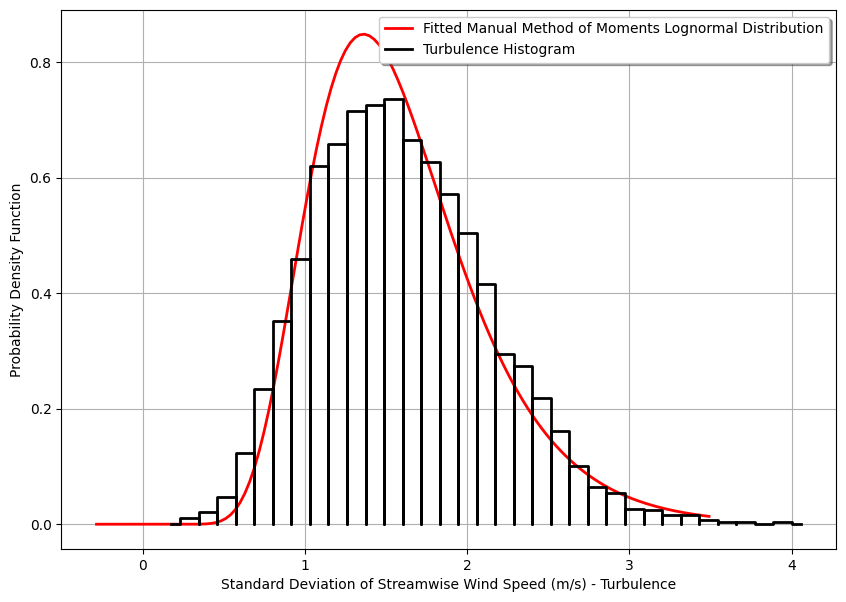

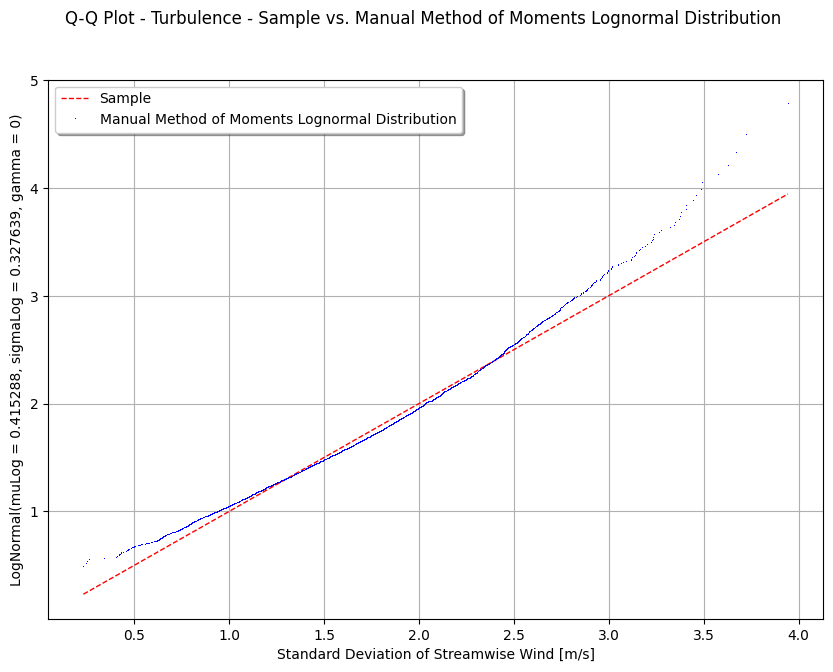

In [21]:
# Method of Moments Lognormal Distribution - Manual
first_moment = site_turbulance_data.computeRawMoment(1)[0] # Mean
second_moment = site_turbulance_data.computeRawMoment(2)[0] # Variance
mu = log(first_moment*first_moment/sqrt(second_moment)) # Mean of Lognormal
sigma = sqrt(log(second_moment/(first_moment*first_moment))) # Standard Deviation of Lognormal
dist_mom_lg_manual = ot.LogNormal(mu,sigma,0.0) # Lognormal Distribution
print(dist_mom_lg_manual)

# Plotting Fitted Distribution over Histogram
plt.rcParams['figure.figsize'] = [10, 7]
graph_mom_lg_manual = dist_mom_lg_manual.drawPDF()
graph_mom_lg_manual.add(graph_site_turbulence)
graph_mom_lg_manual.setXTitle('Standard Deviation of Streamwise Wind Speed (m/s) - Turbulence')
graph_mom_lg_manual.setYTitle('Probability Density Function')
graph_mom_lg_manual.setLegends(['Fitted Manual Method of Moments Lognormal Distribution', 'Turbulence Histogram'])
view = viewer.View(graph_mom_lg_manual)
plt.show()

# Plotting Q-Q Plot
graph_qq_plot = ot.VisualTest.DrawQQplot(site_turbulance_data, dist_mom)
graph_qq_plot.setTitle("Q-Q Plot - Turbulence - Sample vs. Manual Method of Moments Lognormal Distribution")
graph_qq_plot.setLegends(["Sample", "Manual Method of Moments Lognormal Distribution"])
view = viewer.View(graph_qq_plot)
plt.show()

LogNormal(muLog = 10.2755, sigmaLog = 2.07733, gamma = 0)


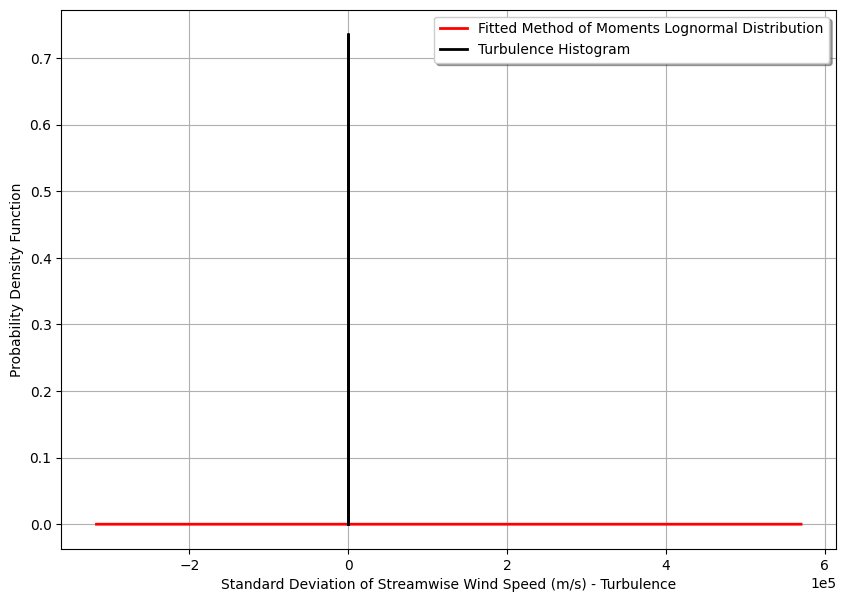

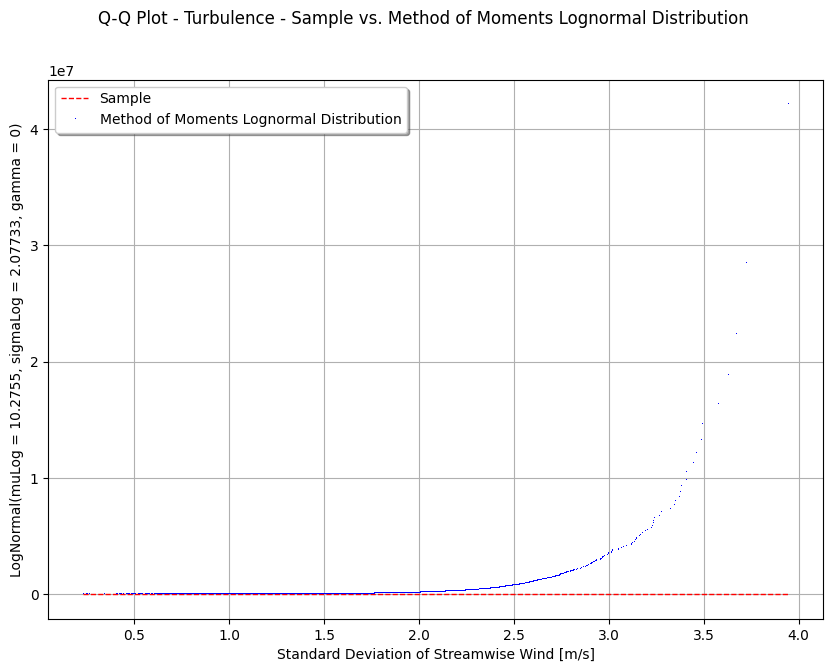

In [29]:
# # Method of Moments Lognormal Distribution - Package
factory_mom_ln = ot.MethodOfMomentsFactory(ot.LogNormal())
factory_mom_ln.setKnownParameter([0.0],[2])
dist_mom_ln = factory_mom_ln.build(site_turbulance_data)
print(dist_mom_ln)

# Plotting Fitted Distribution over Histogram
plt.rcParams['figure.figsize'] = [10, 7]
graph_mom_ln = dist_mom_ln.drawPDF()
graph_mom_ln.add(graph_site_turbulence)
graph_mom_ln.setXTitle('Standard Deviation of Streamwise Wind Speed (m/s) - Turbulence')
graph_mom_ln.setYTitle('Probability Density Function')
graph_mom_ln.setLegends(['Fitted Method of Moments Lognormal Distribution', 'Turbulence Histogram'])
view = viewer.View(graph_mom_ln)
plt.show()

# Plotting Q-Q Plot
graph_qq_plot_2 = ot.VisualTest.DrawQQplot(site_turbulance_data, dist_mom_ln)
graph_qq_plot_2.setTitle("Q-Q Plot - Turbulence - Sample vs. Method of Moments Lognormal Distribution")
graph_qq_plot_2.setLegends(["Sample", "Method of Moments Lognormal Distribution"])
view = viewer.View(graph_qq_plot_2)
plt.show()

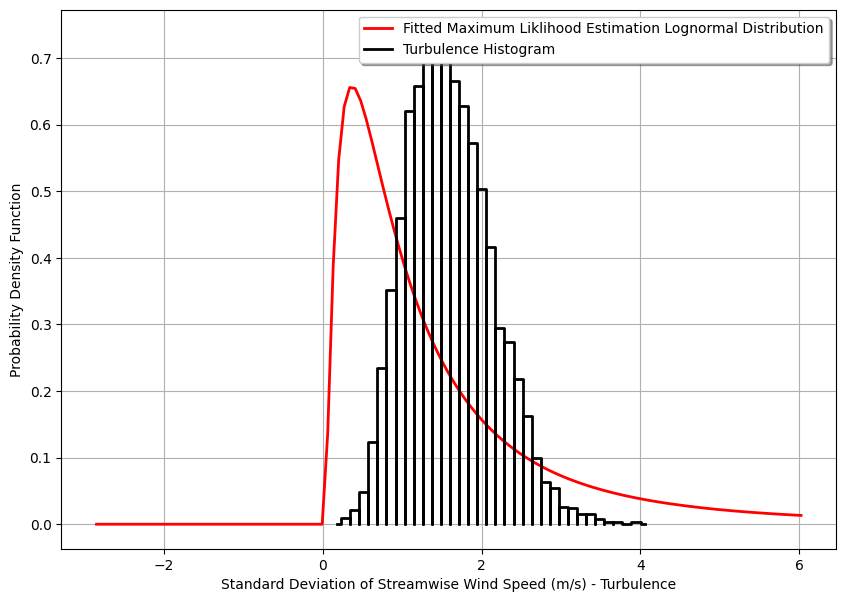

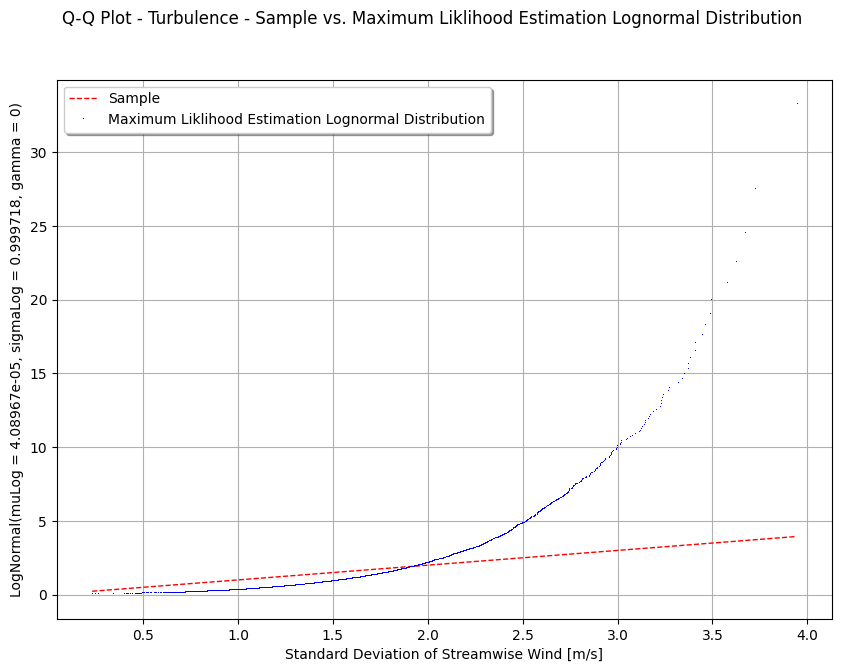

In [30]:
# Lognormal Distribution - Maximum Liklihood Estimation 
factory_mle_ln = ot.MaximumLikelihoodFactory(ot.LogNormal())
factory_mle_ln.setKnownParameter([0.0],[2])
dist_mle_ln = factory_mle_ln.build(site_turbulance_data)
print(dist_mle_ln)

# Plotting Fitted Distribution over Histogram
plt.rcParams['figure.figsize'] = [10, 7]
graph_mle_ln = dist_mle_ln.drawPDF()
graph_mle_ln.add(graph_site_turbulence)
graph_mle_ln.setXTitle('Standard Deviation of Streamwise Wind Speed (m/s) - Turbulence')
graph_mle_ln.setYTitle('Probability Density Function')
graph_mle_ln.setLegends(['Fitted Maximum Liklihood Estimation Lognormal Distribution', 'Turbulence Histogram'])
view = viewer.View(graph_mle_ln)
plt.show()

# Plotting Q-Q Plot
graph_qq_plot_3 = ot.VisualTest.DrawQQplot(site_turbulance_data, dist_mle_ln)
graph_qq_plot_3.setTitle("Q-Q Plot - Turbulence - Sample vs. Maximum Liklihood Estimation Lognormal Distribution")
graph_qq_plot_3.setLegends(["Sample", "Maximum Liklihood Estimation Lognormal Distribution"])
view = viewer.View(graph_qq_plot_3)
plt.show()

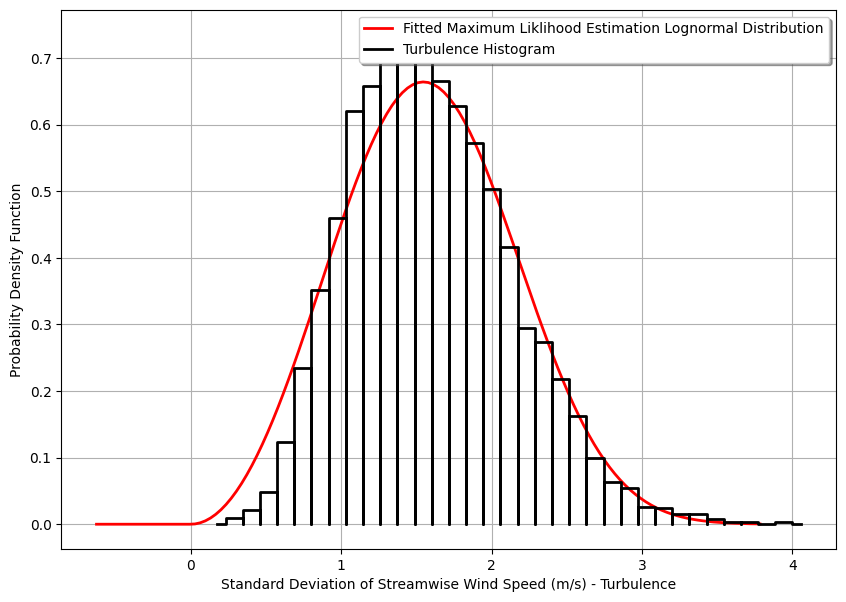

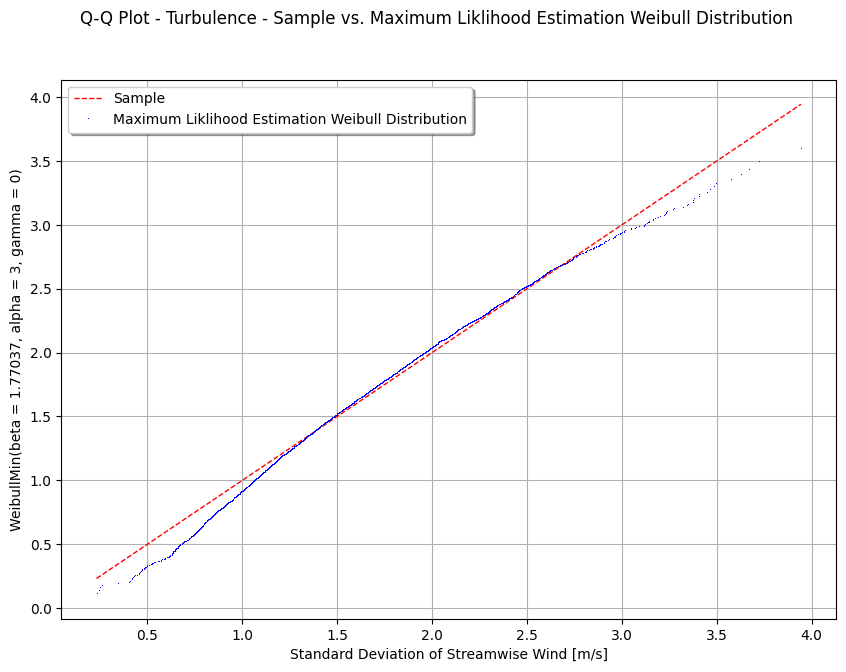

In [34]:
# # Maximum Liklihood Estimation Weibull Distribution - 2 
factory_mle_wbl_2 = ot.MaximumLikelihoodFactory(ot.WeibullMin())
factory_mle_wbl_2.setKnownParameter([0.0],[2])
lowerBound=[0.1, 0.5]
upperBound=[10.0, 3.0]
bounds = ot.Interval(lowerBound, upperBound, [True,True], [True,True])
factory_mle_wbl_2.setOptimizationBounds(bounds)
solver = factory_mle_wbl_2.getOptimizationAlgorithm()
solver.setStartingPoint([5.0,2.0])
dist_mle_wbl_2 = factory_mle_wbl_2.build(site_turbulance_data)
print(dist_mle_wbl_2)

# Plotting Fitted Distribution over Histogram
plt.rcParams['figure.figsize'] = [10, 7]
graph_mle_wbl_2 = dist_mle_wbl_2.drawPDF()
graph_mle_wbl_2.add(graph_site_turbulence)
graph_mle_wbl_2.setXTitle('Standard Deviation of Streamwise Wind Speed (m/s) - Turbulence')
graph_mle_wbl_2.setYTitle('Probability Density Function')
graph_mle_wbl_2.setLegends(['Fitted Maximum Liklihood Estimation Lognormal Distribution', 'Turbulence Histogram'])
view = viewer.View(graph_mle_wbl_2)
plt.show()

# Plotting Q-Q Plot
graph_qq_plot_4 = ot.VisualTest.DrawQQplot(site_turbulance_data, dist_mle_wbl_2)
graph_qq_plot_4.setTitle("Q-Q Plot - Turbulence - Sample vs. Maximum Liklihood Estimation Weibull Distribution")
graph_qq_plot_4.setLegends(["Sample", "Maximum Liklihood Estimation Weibull Distribution"])
view = viewer.View(graph_qq_plot_4)
plt.show()

Gamma(k = 8.49734, lambda = 5.31637, gamma = 0)


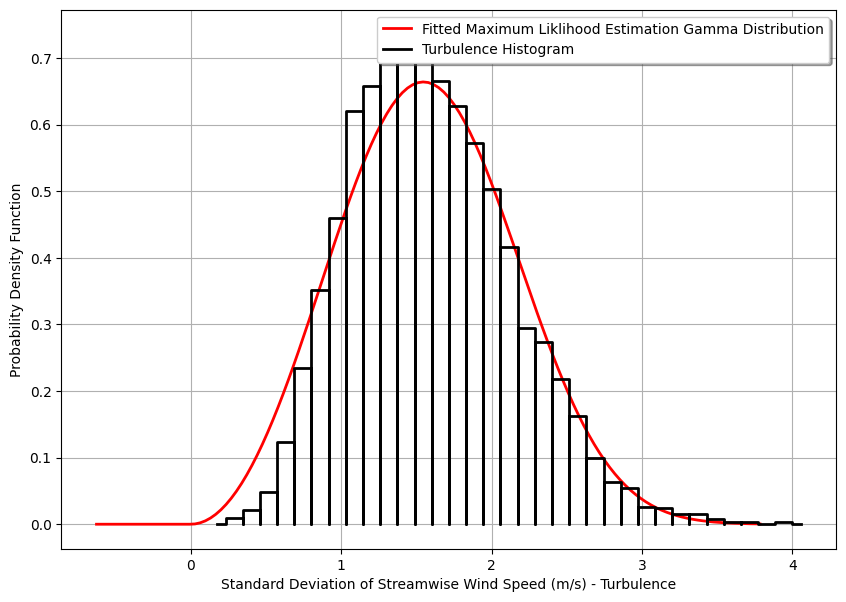

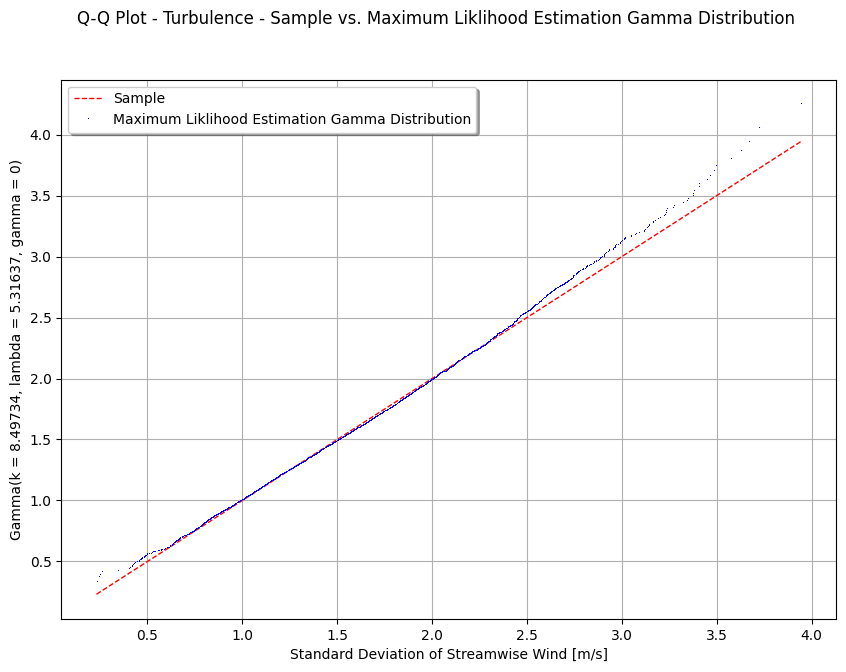

In [36]:
# # Maximum Liklihood Estimation Gamma Distribution
factory_mle_gam = ot.MaximumLikelihoodFactory(ot.Gamma())
factory_mle_gam.setKnownParameter([0.0],[2])
lowerBound=[0.1, 0.1]
upperBound=[10.0, 10.0]
bounds = ot.Interval(lowerBound, upperBound, [True,True], [True,True])
factory_mle_gam.setOptimizationBounds(bounds)
dist_mle_gam = factory_mle_gam.build(site_turbulance_data)
print(dist_mle_gam)

# Plotting Fitted Distribution over Histogram
plt.rcParams['figure.figsize'] = [10, 7]
graph_mle_wbl_2 = dist_mle_wbl_2.drawPDF()
graph_mle_wbl_2.add(graph_site_turbulence)
graph_mle_wbl_2.setXTitle('Standard Deviation of Streamwise Wind Speed (m/s) - Turbulence')
graph_mle_wbl_2.setYTitle('Probability Density Function')
graph_mle_wbl_2.setLegends(['Fitted Maximum Liklihood Estimation Gamma Distribution', 'Turbulence Histogram'])
view = viewer.View(graph_mle_wbl_2)
plt.show()

# Plotting Q-Q Plot
graph_qq_plot_5 = ot.VisualTest.DrawQQplot(site_turbulance_data, dist_mle_gam)
graph_qq_plot_5.setTitle("Q-Q Plot - Turbulence - Sample vs. Maximum Liklihood Estimation Gamma Distribution")
graph_qq_plot_5.setLegends(["Sample", "Maximum Liklihood Estimation Gamma Distribution"])
view = viewer.View(graph_qq_plot_5)
plt.show()

WeibullMin(beta = 1.5, alpha = 2.7428, gamma = 0.204888)


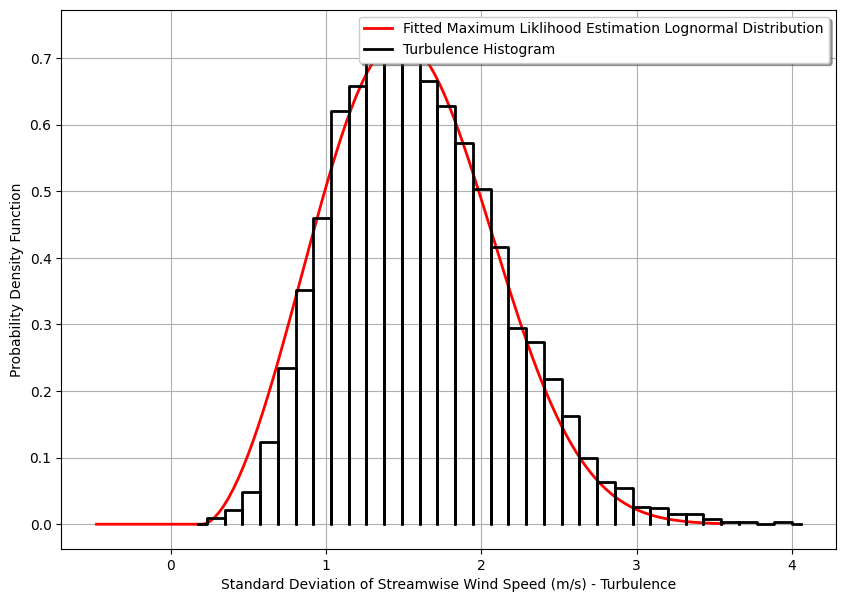

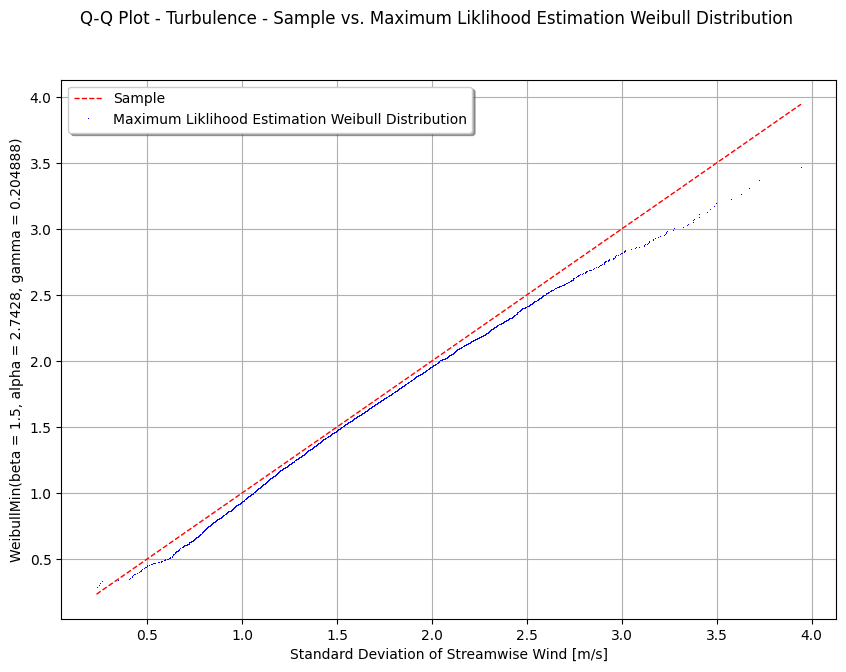

In [39]:
# # Maximum Liklihood Estimation Weibull Distribution - 3 Parameter
factory_mle_wbl3 = ot.MaximumLikelihoodFactory(ot.WeibullMin())
lowerBound=[1.5, 2.5, 0.0]
upperBound=[2.0, 3.5, 1.0]
bounds = ot.Interval(lowerBound, upperBound, [True,True,True], [True,True,True])
factory_mle_wbl3.setOptimizationBounds(bounds)
solver = factory_mle_wbl3.getOptimizationAlgorithm()
solver.setStartingPoint([1.8,3.0,0.0])
dist_mle_wbl_3 = factory_mle_wbl3.build(site_turbulance_data)
print(dist_mle_wbl_3)


# Plotting Fitted Distribution over Histogram
plt.rcParams['figure.figsize'] = [10, 7]
graph_mle_wbl_3 = dist_mle_wbl_3.drawPDF()
graph_mle_wbl_3.add(graph_site_turbulence)
graph_mle_wbl_3.setXTitle('Standard Deviation of Streamwise Wind Speed (m/s) - Turbulence')
graph_mle_wbl_3.setYTitle('Probability Density Function')
graph_mle_wbl_3.setLegends(['Fitted Maximum Liklihood Estimation Lognormal Distribution', 'Turbulence Histogram'])
view = viewer.View(graph_mle_wbl_3)
plt.show()

# Plotting Q-Q Plot
graph_qq_plot_5 = ot.VisualTest.DrawQQplot(site_turbulance_data, dist_mle_wbl_3)
graph_qq_plot_5.setTitle("Q-Q Plot - Turbulence - Sample vs. Maximum Liklihood Estimation Weibull Distribution")
graph_qq_plot_5.setLegends(["Sample", "Maximum Liklihood Estimation Weibull Distribution"])
view = viewer.View(graph_qq_plot_5)
plt.show()


TTD:
Use quantative method to assess which fit is the best, e.g.:
    Kolmogorov-Smirnov Test
    Anderson-Darling Test
    Cramer-von Mises Statistic
    Quantile-Quantile Plot Residuals
    Chi-Square Test for Binning
